# Forecasting of daily River Discharge (RD) based on temperature and precipitation of the day, previous RD and previous Precipitation

### Import of libraries

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
from sklearn import linear_model,preprocessing
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error,r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split

### LoadingData

In [44]:
def loadData(river,rdDaysBefore,precDaysBefore=0):
    data=pd.read_csv(river).values
    Xbefore = data[:,1:4]
    rd_column = Xbefore[:,0]
    rd_column = np.roll(rd_column,rdDaysBefore)
    Xbefore[:,0] = rd_column
    if precDaysBefore != 0:
        prec_colum = Xbefore[:,2]
        prec_colum = np.roll(prec_colum,precDaysBefore)
        new_column = np.expand_dims(prec_colum, axis=1)
        Xbefore = np.hstack((Xbefore, new_column))
    cut = rdDaysBefore if rdDaysBefore > precDaysBefore else precDaysBefore
    X = Xbefore[cut:,:]
    y = data[cut:,1]
    return X,y

### Prep of Data

In [45]:
def preprocess_data(X,y):
    scaler = preprocessing.StandardScaler()
    poly_features = preprocessing.PolynomialFeatures(degree=2)

    train_size = int(len(y)*0.6)
    validation_size = int(len(y)*0.2)

    X_train = X[:train_size,:]
    y_train = y[:train_size]
    X_val = X[train_size:train_size+validation_size,:]
    y_val = y[train_size:train_size+validation_size]
    X_test = X[train_size+validation_size:,:]
    y_test = y[train_size+validation_size:]


    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    X_val_poly = poly_features.transform(X_val)
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)
    X_val_scaled = scaler.transform(X_val_poly)


    return X_train_scaled, y_train, X_test_scaled, y_test,X_val_scaled,y_val

### Cost Function

In [46]:
def validationCurve(X, y, X_val, y_val, lambda_array):

    m = len(y)  # Number of training examples 
    n= X.shape[1]  # number of features 
    mval = len(y_val)  # Number of validation examples 
    
    error_train, error_val = [],[]
    
    for lam in lambda_array:
        # inicialize theta vector with zeros
        
        # call gradientDescent to compute the optimal theta 
        model = linear_model.Ridge(alpha=lam)
        model.fit(X,y)
                
        #After the training is over, apply the trained model for train and validation data
        pred_train = model.predict(X)
        pred_val =  model.predict(X_val)
        
        #Compute the train and validation error
        error_train_i = 1/(2*m) * np.sum((pred_train - y)**2)
        error_val_i = 1/(2*mval) * np.sum((pred_val - y_val)**2)
        
        error_train.append(error_train_i)
        error_val.append(error_val_i)
    
    #Choose the best lambda to be the one that minimizes the validation error
    ind = np.argmin(error_val)
    best_lambda=lambda_array[ind]

    return best_lambda, error_train, error_val

In [47]:
def test_for_river(river):

    best_rmse = (np.inf,0)
    alphas = [0.01,0.1,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
    memoryRd = [x for x in range(1,11)] + [x for x in range(10,360,15)]
    memoryprec = [x for x in range(1,11)] + [x for x in range(10,360,15)]

    for i in memoryRd:
        for j in memoryprec:
            X, y = loadData(river, i,j)
            X_train_scaled, y_train, X_test_scaled, y_test,X_val_scaled,y_val = preprocess_data(X, y)
            best_lambda, error_train, error_val = validationCurve(X_train_scaled, y_train,X_val_scaled, y_val,alphas)
            if min(error_val) < best_rmse[0]:
                best_rmse = (min(error_val), i, j,best_lambda)
            
    print("\n\n ----- TESTING FOR RIVER:", river + " ------ \n\n")
    print("Best memoryRD and memoryPrecipitacao and best lambda for best MSE:", best_rmse[1:])
    X, y = loadData(river, best_rmse[1], best_rmse[2])
    X_train_scaled, y_train, X_test_scaled, y_test,X_val_scaled,y_val = preprocess_data(X, y)
    model = linear_model.Ridge(alpha=best_rmse[3])
    model.fit(X_train_scaled,y_train)
    predicted = model.predict(X_test_scaled)
    r2 = r2_score(y_test, predicted)
    plt.plot(y_test,label="test values")
    plt.plot(predicted,'--',label="predicted")
    plt.legend()
    mse = mean_squared_error(y_test, predicted)
    print("R2:", r2)
    print("MSE:", mse)
    print("RMSE:", np.sqrt(mse))



 ----- TESTING FOR RIVER: RD_data/RD_AntuaR_pg.csv ------ 


Best memoryRD and memoryPrecipitacao and best lambda for best MSE: (250, 175, 0.01)
R2: 0.9999999944808414
MSE: 1.3062588508886474e-07
RMSE: 0.00036142203182548894


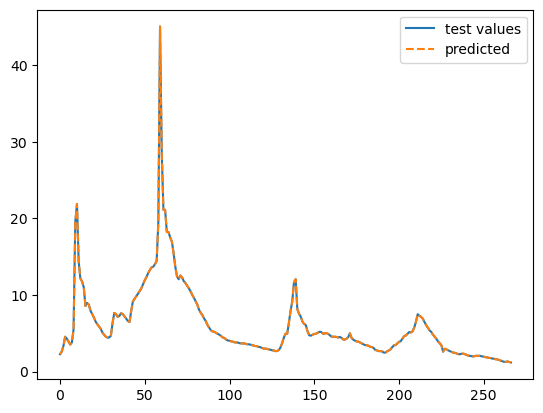

In [48]:
test_for_river("RD_data/RD_AntuaR_pg.csv")
#test_for_river("RD_data/RD_MondegoR_pg.csv")
#test_for_river("RD_data/RD_NeivaR_pg.csv")
#test_for_river("RD_data/RD_VougaR_pg.csv")